# 1. Introduction to the Visium Dataset

The **Visium** dataset is generated using the 10x Genomics Visium platform and is designed for spatial transcriptomics studies. This dataset provides:

- **Spatial Coordinates:** Each spot is associated with spatial coordinates mapping its position in the tissue.
- **Gene Expression Data:** High-dimensional expression profiles measured across many spots.
- **Tissue Imaging:** High-resolution histological images that help in correlating gene expression with tissue morphology.

These features allow researchers to investigate spatial patterns of gene expression, identify spatially variable genes, and gain insights into tissue architecture and cell organization.

In the code below, we will load the Visium dataset using Squidpy and Scanpy, explore its basic properties, and visualize the spatial layout of the tissue.


In [35]:
import squidpy as sq
import scanpy as sc

# Load the Visium dataset
adata = sq.datasets.visium_hne_adata()

# Explore basic information about the dataset
print("AnnData object:")
print(adata)

# View the first few observations (metadata for each spot)
print("\nObservations (metadata):")
print(adata.obs.head())

# View the first few variables (genes)
print("\nVariables (genes):")
print(adata.var.head())

# Summary statistics of the gene expression matrix
print("\nSummary of gene expression (X):")
print(adata.X.shape)


AnnData object:
AnnData object with n_obs × n_vars = 2688 × 18078
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

Observations (metadata):
                    in_tissue  array_row  array_col  n_genes_by_counts  \
AA

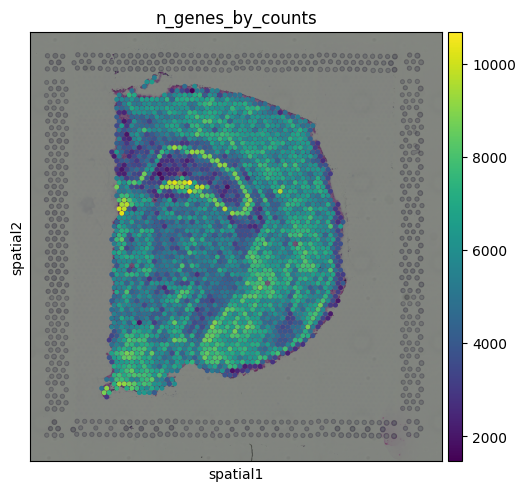

In [36]:
# Visualize the spatial layout of the tissue, coloring by the number of genes detected per spot.
sq.pl.spatial_scatter(
    adata,
    color="n_genes_by_counts",
    library_key="library_id", 
    size=1.5
)

This figure shows a **Visium spatial transcriptomics tissue section** where each **hexagonal spot** corresponds to a specific location on the tissue slide. The spots are colored by the metric **“n_genes_by_counts,”** which represents the number of detected genes in each spot.

- **Shape of the Tissue:**  
  The tissue has a roughly “D” shape, with an outer boundary of spots outlining the perimeter.

- **Color Gradient:**  
  - **Yellow Spots:** High number of detected genes  
  - **Blue/Teal Spots:** Lower number of detected genes  
  This gradient highlights spatial variation in gene capture across the tissue section.

- **Spatial Axes:**  
  The x-axis (`spatial1`) and y-axis (`spatial2`) correspond to the physical coordinates of the spots on the tissue slide.

Overall, the plot reveals **regional differences** in gene detection that may reflect distinct morphological or functional areas within the tissue.


# 2. Compute Spatial Neighbors

We build a spatial graph using the tissue coordinates available in `adata.obsm["spatial"]`. Since Visium data are arranged in a grid, we use `coord_type="grid"` and set the number of neighbors (e.g., `n_neighs=6`). This graph is essential for subsequent spatial analyses.


In [37]:
import squidpy as sq

# Build the spatial neighbor graph (using grid coordinates)
sq.gr.spatial_neighbors(adata, coord_type="grid", n_neighs=6)

adata

AnnData object with n_obs × n_vars = 2688 × 18078
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap', 'spatial_neighbors'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

we are building a spatial neighbor graph for each spot in the tissue. In other words, we create a graph in which:

- Each node (vertex) is a spot in the Visium array.
- An edge (connection) between two nodes indicates those spots are close to each other in physical space.

Once sq.gr.spatial_neighbors is done, we’ll find two new matrices in adata.obsp:

adata.obsp["spatial_connectivities"] – The adjacency matrix (which spots are connected).
adata.obsp["spatial_distances"] – The distance matrix (the spatial distance between connected spots).

# 3. Calculate Spatial Autocorrelation (Moran’s I)

We use Moran's I to assess the degree of spatial autocorrelation for gene expression. This global statistic helps identify genes whose expression patterns are spatially structured. Here, we compute Moran’s I for a subset (e.g., the first 50) of genes.


In [38]:
# Compute Moran's I for the first 50 genes
sq.gr.spatial_autocorr(adata, mode="moran", genes=adata.var_names[:50])

# The results are stored in adata.uns["moranI"]
print(adata.uns["moranI"].head())


                      I  pval_norm  var_norm  pval_norm_fdr_bh
3110035E14Rik  0.665132        0.0  0.000131               0.0
Rpl7           0.398118        0.0  0.000131               0.0
Sulf1          0.348834        0.0  0.000131               0.0
A830018L16Rik  0.245147        0.0  0.000131               0.0
Oprk1          0.165270        0.0  0.000131               0.0


# 4. Neighborhood Enrichment Analysis

This analysis tests whether the spatial arrangement of cell clusters (here, defined by the Leiden algorithm in `adata.obs["leiden"]`) is non-random. It quantifies if cells in a given cluster are more likely to be neighbors than expected by chance.


In [39]:
# Perform neighborhood enrichment analysis based on Leiden clusters
sq.gr.nhood_enrichment(adata, cluster_key="leiden")

100%|██████████| 1000/1000 [00:09<00:00, 103.64/s]


# 5. Visualize Spatial Patterns

Finally, we visualize the spatial layout of the tissue. This includes plotting the clusters on the tissue section. Wecan also explore the spatial expression of individual genes if desired.


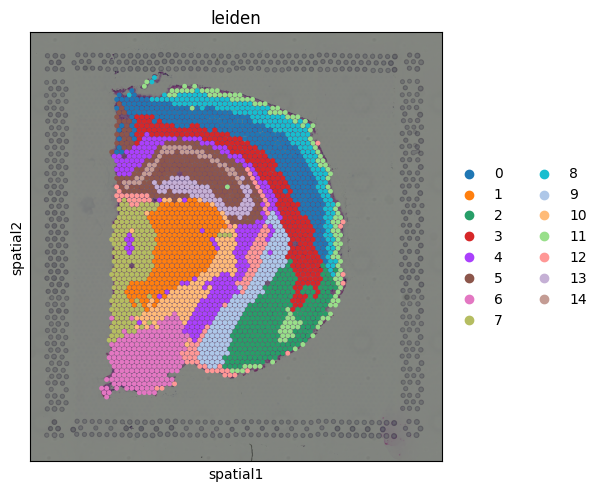

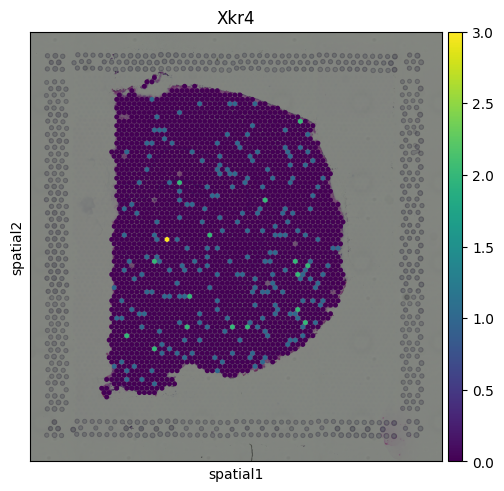

In [40]:
# Visualize the spatial distribution of the Leiden clusters
sq.pl.spatial_scatter(adata, color="leiden", size=1.5)

# To visualize the spatial expression of a gene, for example, the first gene:
gene_to_plot = adata.var_names[0]
sq.pl.spatial_scatter(adata, color=gene_to_plot, size=1.5)
